# A5e
Finn Hittson - fxh157  
CSDS 464  
Due May 1st, 2023

## Recap
For my research extension I am trying to build a beat detection system. This is an implementation of an algorithm proposed in the paper *Streamlined Tempo Estimation Based on Autocorrelation and Cross-correlation With Pulses*, written by Graham Percival and George Tazanetakis.  
In my previous progress report I had completed and functional implementation of the entire beat detection algorithm. However, my implementation was incorrect and produced inaccurate estimates for submitted audio.

## A5e Progress
For this progress report I compared my own implementation to the implementation provided by the paper authors. I then use any differences to find mistakes and hopefully correct my code so that it can produce the same figures and outputs as those described in the paper.

### Low-pass filter
The filter described in the paper is a low-pass $14$th order FIR filter with a cutoff frequency of $7Hz$. The previous step, the flux calculation, also explains that the signal's sample rate is reduced from $44100Hz$ to $344.5Hz$. Not surprisingly, the authors generate filter coefficients for $14$th order, which matched their paper, but with a cutoff frequency of $0.035Hz$ and a sampling frequency of $2Hz$, not $344.5Hz$. 

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
from scipy.io import wavfile
import scipy
import numpy as np
import math

import OSS as oss
import BPD as bpd
import accumulate as acc
import plotters

### 1. Onset Signal Strength (OSS)

#### Overlap

The first thing I found was that the authors parse their audio signal into frames of length $256$ instead of $1024$ as listed in the paper. The hop size stayed the same at $128$. I found this to be questionable since decreasing the window size causes the sampling frequency to approach the Nyquist frequency. With a smaller window beats will be further spaced with more windows between them. Then when they are corss correlated, a window with a beat in it will be correlated with a window that does not have a beat in it. The top correlation will then be considered as a tempo candidate when it should not be. With larger window sizes it is more likely that there will be at least one beat per window. However, an advantage to having a smaller window size is that true beat correlations will be stronger and may be accuratly determined when compiling all tempo candidates in the accumulation stage of the algorith. I try both window sizes and found that neither were able to accuratly determine the correct tempo of the audio signal. 

In [2]:
filepath = "ballroom.wav"
sr, data = oss.read_wav(filepath)
print(f"sampling rate: {sr}Hz")
print(f"audio length: {round(len(data)/sr, 3)} seconds")
#plot_signal(data=data, sr=sr, stop=6, title="Raw Signal")

sampling rate: 44100Hz
audio length: 31.788 seconds


calculated frame count: 10950 frames
returned frame count: 10950 frames
(10950, 256)


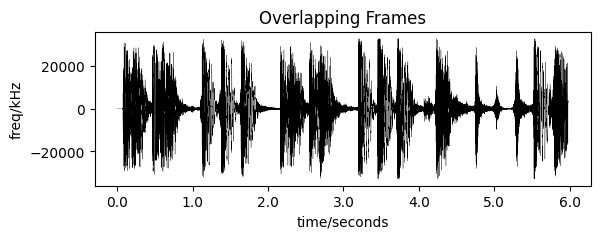

In [3]:
framesize = 256
hop = 128
print(f"calculated frame count: {1+math.floor((len(data)-framesize)/hop)} frames")
frames = oss.get_frames(data=data, framesize=framesize, hop=hop)
print(f"returned frame count: {len(frames)} frames")
frames6 = frames[:2059]
print(frames.shape)
plotters.plot_frames(frames=frames6, sr=44100, framesize=1024, hop=128, title="Overlapping Frames")

#### Log power spectrum

In [4]:
tappered_frames = oss.hamming_window(frames)
tappered_frames6 = oss.hamming_window(frames6)
# compute the discrete fourier transform of the frames
fft_frames = scipy.fft.fft(tappered_frames, n=framesize, axis=1)
fft_frames6 = scipy.fftpack.fft(x=tappered_frames6, n=framesize, axis=1)
fft_frames6 = abs(fft_frames6)[:,:fft_frames6.shape[1]//2 + 1]
fft_frames6 /= framesize

In [5]:
log_power = np.array(oss.comp_log_power(fft_frames))
log_power6 = np.array(oss.comp_log_power(fft_frames6))

print(fft_frames.shape)
print(fft_frames6.shape)
print(log_power.shape)
print(log_power6.shape)

diff = log_power6[0] - np.zeros(fft_frames6.shape[1])
print(diff)
diffreduced = diff[1:]
print(diffreduced)
diffclipped = diffreduced.clip(min=0)
print(diffclipped)
print(sum(diffclipped))

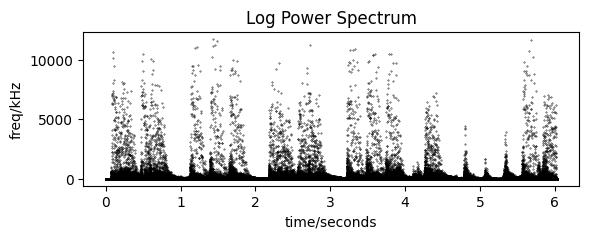

In [6]:
plotters.plot_log_spectrum(fft_frames6, framesize=framesize, hop=hop, sr=44100)

#### Flux

Interestingly, my flux calculation matches the implementation of the authors. The overlap and log power spectrum were also identical. For reference, the flux equations is provided below with my implementation and the authors.
$$
Flux(n)=\sum_{k=1}^{N-1}(L_P(k,n)-L_P(k,n-1))\cdot I_{PF}(k,n)
$$
$$
I_{PF}(k,n)=
\begin{cases}
1 & 0\ \textrm{if}\ |X(k,n)|-|X(k,n-1)|\le0\\
0 & 1\ \textrm{otherwise}
\end{cases}
$$
My implementation.
```
def comp_flux_old(log_power):
  flux = np.zeros(len(log_power)-1)
  for n in range(1, len(log_power)):
    for k in range(len(log_power[n])):
      if abs(log_power[n,k]) > abs(log_power[n-1,k]):
        flux[n] += log_power[n,k] - log_power[n-1,k]
  return flux
```
The authors implementation.
```
def comp_flux(log_power):
  flux = np.zeros(log_power.shape[0])
  prev = np.zeros(log_power.shape[1])
  for i in range(log_power.shape[0]):
    diff = log_power[i] - prev
    diff_reduced = diff[1:]
    diff_clipped = diff_reduced.clip(min=0)
    prev = np.copy(log_power[i])
    flux[i] = sum(diff_clipped)
  return flux
```
The authors more helper functions to execute this equation but the output is the same. However, this does not solve my problem related to recreating the flux figure supplied in the paper. This leads me to believe that the authors generated thier figures using separate methods that are not provided in the paper or in their source code. Upon reading other sources for basic flux calculations and those related to flux calculations for signal onset detection, which is what this step is trying to achieve, I believe that my implementation is correct so the resulting plot my be misleading since it is not identical to the plot provided in the paper.

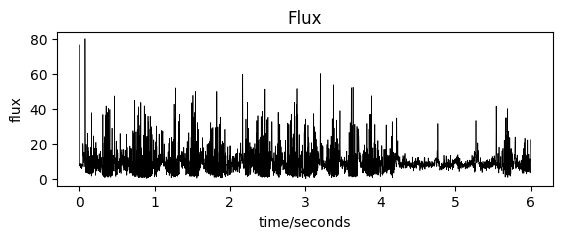

In [9]:
flux6 = oss.comp_flux_author(log_power6)
plotters.plot_flux(flux6)

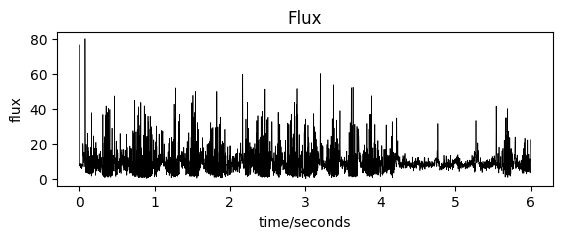

In [ ]:
flux = oss.comp_flux(log_power)
flux6 = oss.comp_flux(log_power6)
plotters.plot_flux(flux6)

#### Low-pass filter

The filter described in the paper is a low-pass $14th$ order FIR filter with a cutoff frequency of $7Hz$. The previous step, the flux calculation, also explains that the signal's sample rate is reduced from $44100Hz$ to $344.5Hz$. Not surprisingly, the authors generate filter coefficients for $14th$ order, which matched their paper, but with a cutoff frequency of $0.035Hz$ and a sampling frequency of $2Hz$, not $7Hz$ for the cutoff or $344.5Hz$ for the sampling frequency. This change is likely related to the change in window size and filtering strategy. However, their reasoning was not explained in the paper.

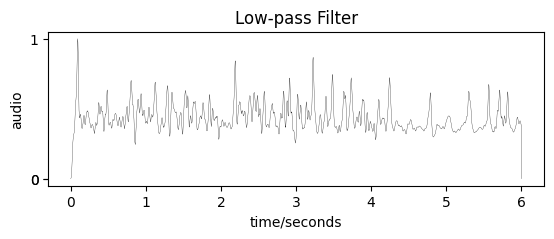

In [ ]:
filtered_signal = oss.low_pass_filter(flux=flux)
filtered_signal6 = oss.low_pass_filter(flux=flux6)
plotters.plot_signal(filtered_signal6, sr=344.5, title="Low-pass Filter")

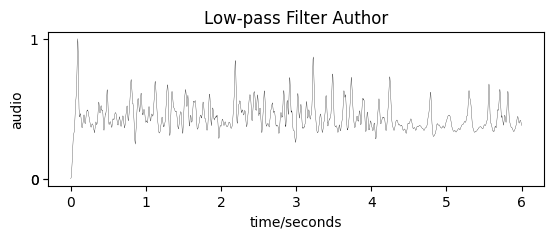

In [ ]:
filtered_signal6_author = oss.low_pass_filter_author(flux=flux6)
plotters.plot_signal(filtered_signal6_author, sr=344.5, title="Low-pass Filter Author")

In [ ]:
#print(f"filter calculation difference: {sum(filtered_signal6 - filtered_signal6_author)}")

ValueError: operands could not be broadcast together with shapes (2060,) (2059,) 

### Step 2: Beat Period Detection

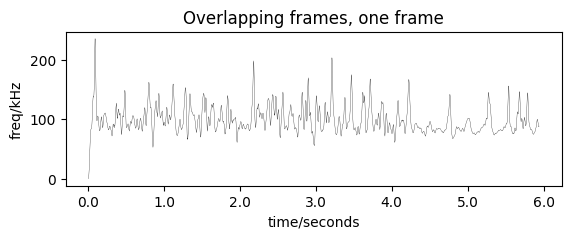

In [ ]:
frames = bpd.overlap(data=filtered_signal, framesize=2048, hop=128)
plotters.plot_frames(frames=frames[0], sr=344.5, framesize=2048, hop=128, title="Overlapping frames, one frame")

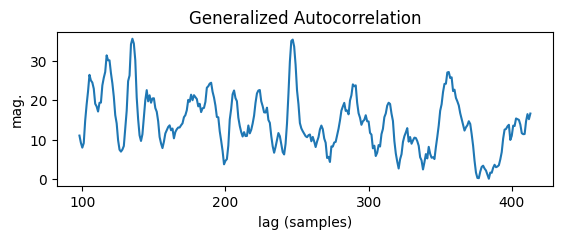

In [ ]:
A = bpd.autocorrelation(signal=frames)
plotters.plot_correlation(A=A[0], title="Generalized Autocorrelation")

EAC = bpd.enhance_harmonics(A=A)
plotters.plot_correlation(A=EAC[0], title="Enhanced Harmonics")

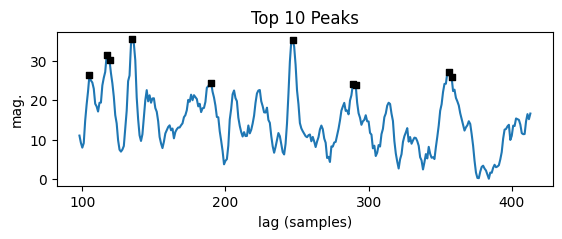

In [ ]:
indices, values = bpd.pick_peaks(A=A)
idx = 0
plotters.plot_correlation(A=A[0], start=98+316*idx, stop=414+316*idx, indices=indices[idx], values=values[idx], title="Top 10 Peaks")

In [ ]:
Lm = bpd.evaluate_pulse_train(indices[0], frames[0])
print(f"{int(round(344.5*60/Lm, 0))} bpm")

559 bpm


### Step 3: Accumulation and overall estimate

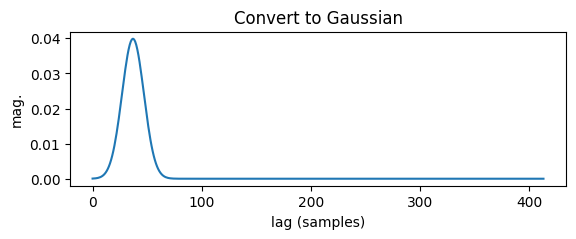

In [ ]:
plotters.plot_gaussian(Lm=Lm, g=acc.Gm, title="Convert to Gaussian")

c:\Users\hitts\Dropbox\PC\Documents\GitHub\beat\src\BPD.py:85: RuntimeWarning: invalid value encountered in divide
  return SCv/np.linalg.norm(SCv), SCx/np.linalg.norm(SCx)


overall estimate: 94 bpm


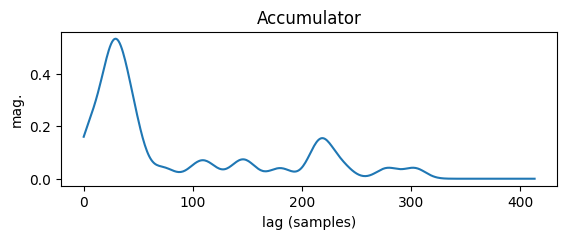

In [ ]:
Lms = acc.eval_entire_signal(indices, frames)
y = acc.accumulate_gauss(Lms=Lms)
idxs, vals = bpd.find_local_maximums(np.concatenate((np.zeros(98), y[98:])))
print(f"overall estimate: {int(round(344.5*60/idxs[-1], 0))} bpm")
plotters.plot_gaussian(Lm=y, g=acc.Gm, title="Accumulator")